## Imports and Definitions ##

In [1]:
import pandas as pd
import shap
from datasets import Dataset, DatasetDict
import torch
from transformers import pipeline
from sklearn.model_selection import train_test_split
import numpy as np

checkpoint = 'bert-base-multilingual-uncased'
classifier_type = 'product'
model_path = f'/scratch/{checkpoint}/results_{classifier_type}'
dataset_path = '/scratch/data_processed.csv'
seed = 3
p_label = 'SAP Business Warehouse & Business Objects' # Predicted Label
t_label = 'SAP Business Warehouse & Business Objects' # True Label

device = 'cuda' if torch.cuda.is_available() else 'cpu'
classifier = pipeline(task='sentiment-analysis', model=model_path, return_all_scores=True, truncation=True, device=0 if device == 'cuda' else -1)

`return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


## Load the Dataset and Convert it to a HuggingFace Dataset ##

In [2]:
df = pd.read_csv(dataset_path)
df = df.dropna(subset=[classifier_type])
df = df.rename(columns={classifier_type: 'labels'})

# Filter out classes with counts less than 3
label_counts = df['labels'].value_counts()
classes_to_keep = label_counts[label_counts > 2].index.tolist()
df = df[df['labels'].isin(classes_to_keep)]

# Convert textual labels to unique integers
unique_labels = df['labels'].unique()
label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
id_to_label = {idx: label for label, idx in label_to_id.items()}
df['labels'] = df['labels'].map(label_to_id)

train_df, remaining_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=seed)
test_df, validation_df = train_test_split(remaining_df, test_size=0.5, stratify=remaining_df['labels'], random_state=seed)

# Convert to a HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
validation_dataset = Dataset.from_pandas(validation_df)

data = DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
    'validation': validation_dataset
})

## Identify Instances to Explain ##

In [3]:
df = data['test']
instances_to_explain = []

for row in df:
    text_instance = row['text']
    true_label = id_to_label[row['labels']]
    
    prediction = max(classifier(text_instance, truncation=True)[0], key=lambda x: x['score'])
    predicted_label = prediction['label']
    
    if (predicted_label == p_label and true_label == t_label):
        instances_to_explain.append(text_instance)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


## Calculate SHAP Values Using PartitionExplainer With Custom Masker ##

In [4]:
masker = shap.maskers.Text(tokenizer=r"\W+")
explainer = shap.Explainer(classifier, masker)
shap_values = explainer(instances_to_explain)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Partition explainer:   8% 2/26 [00:00<?, ?it/s]

Partition explainer:  19% 5/26 [00:22<00:58,  2.77s/it]

Partition explainer:  27% 7/26 [00:32<01:14,  3.93s/it]

Partition explainer:  42% 11/26 [00:52<01:10,  4.72s/it]

Partition explainer: 27it [02:06,  5.07s/it]            


## Bar Plot for Influential Features ##

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


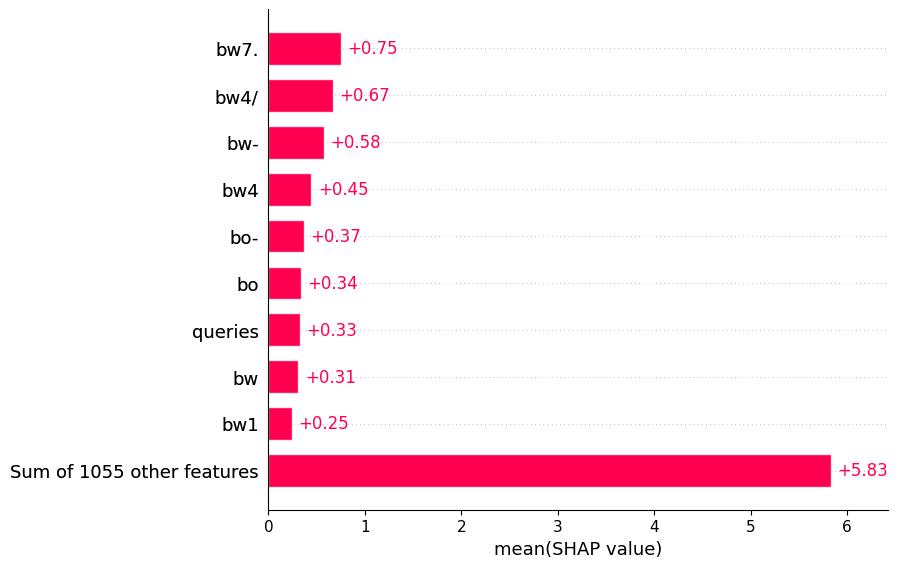

In [5]:
# If instances_to_explain contains only one instance, use this instead
# shap.plots.bar(shap_values[0, :, p_label], max_display=10, order=shap.Explanation.argsort.flip, clustering_cutoff=0)

shap.plots.bar(shap_values[:, :, p_label].mean(0), max_display=10, order=shap.Explanation.argsort.flip)